In [1]:
import time
start_time=time.time()

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy import interpolate

Data load

In [3]:
pickle_in = open('CarC.pkl',"rb")
data = pickle.load(pickle_in)
data

,X,Y,RV
0,160.9408,-59.51381,-7.175543
1,161.2433,-59.55172,-7.391660
2,161.2100,-59.59631,-9.893945
3,161.1413,-59.58192,-22.703236
4,161.3221,-59.70569,-12.487097
...,...,...,...
861,160.9409,-59.55744,-6.430415
862,160.9275,-59.54794,-8.695479
863,160.8832,-59.56567,-8.319904
864,160.9601,-59.56681,-9.309055


Bidimensional Data Display

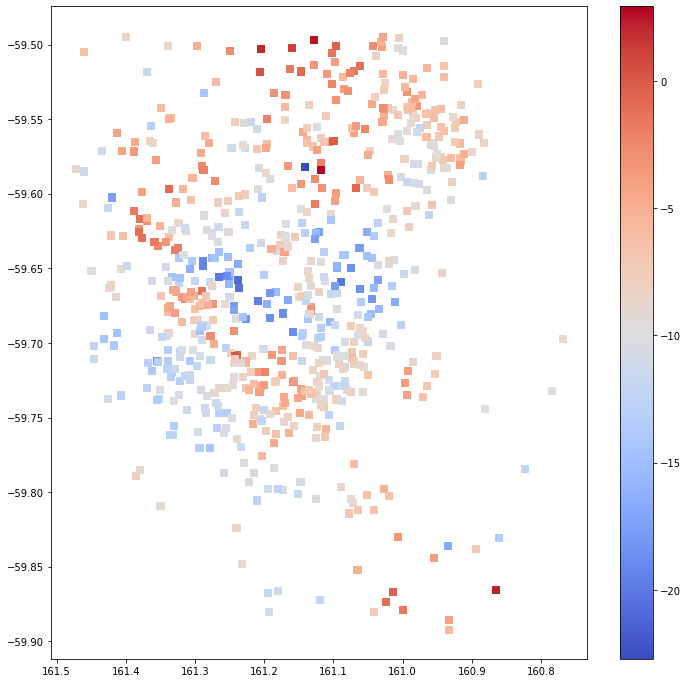

In [4]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(data.X,data.Y,c=data.RV, s=50,marker='s',cmap='coolwarm')
plt.colorbar()
ax.invert_xaxis()
#plt.axis('equal')

Second order Structure Function:
$$S_{2}(l)=\langle {\vert \overrightarrow{v}(\overrightarrow{x}+\overrightarrow{l})-\overrightarrow{v}(\overrightarrow{x}) \vert}^{2} \rangle \propto (\epsilon l)^{2 / 3} $$
applied to the bidimensional map (Turbulence case)

Data Rearrange

In [5]:
df1=data[['X', 'Y', 'RV']].copy()
df1n=df1.to_numpy()

In [6]:
xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

Structure Function code

In [7]:
sig2=2*(data.RV.var())
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

In [8]:
a=[[0]*(l) for i in range(l)]
b=[[0]*(l) for i in range(l)]
c=[[0]*(2) for i in range(l*l)]

In [9]:
#Second Order Structure Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(((f[j][0])-(f[i][0]))**2)

#Normalized Second Order Structure Function Matrix [LxL]
#for i in range(l):
#    for j in range(l):
#        if i > j:
#            a[i][j]=(((f[j][0]-fm)-(f[i][0]-fm))**2)/(fv)       

In [10]:
#Coord Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5 

In [11]:
#LxL to Lx2
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]

In [12]:
#pd.DataFrame(a)

In [13]:
#pd.DataFrame(b)

In [14]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,1])>0.0
e=d[ind]

df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,365085.000000,3.650850e+05
mean,0.191674,3.577444e+01
std,0.105308,5.105823e+01
min,0.000000,3.801128e-11
25%,0.111087,3.487991e+00
50%,0.178338,1.586638e+01
75%,0.257944,4.676820e+01
max,0.719194,6.566131e+02


In [15]:
#ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
#ax.fig.set_size_inches(8,8)

Structure Function Data Groups

In [16]:
m=1#separation between lags mib valu=min lag

In [17]:
n=df.lag.max()//m#Number of points
n

0.0

In [18]:
#Grouping points
dfx = dict()

for i in range(int(n)):
    p = 0 + i*m
    q = m + i*m
    dfx[i] = df[df['lag'].between(p,q)]
    
dfx

{}

In [19]:
#Log Grouping 
d_log_s = 2.5
log_s_min = np.min(df["lag"])
#log_s_min = 1.0
ils = ((df["lag"] - log_s_min) / d_log_s).astype(int).rename("ils")
ils[ils < 0] = 0

In [20]:
table0 = df[['lag', 'qvd']].groupby(ils).describe()
table0

lag                                                         \
        count      mean       std  min       25%       50%       75%   
ils                                                                    
0    365085.0  0.191674  0.105308  0.0  0.111087  0.178338  0.257944   

                    qvd                                                \
          max     count       mean        std           min       25%   
ils                                                                     
0    0.719194  365085.0  35.774443  51.058228  3.801128e-11  3.487991   

                                       
           50%        75%         max  
ils                                    
0    15.866382  46.768197  656.613128

Main Matrix Statistical Properties Groups

In [21]:
lgp=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

In [22]:
n=len(dfx)

for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/np.sqrt(dl[i])
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/np.sqrt(dl[i])  


In [23]:
g=[[0]*(7) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=dfs[i]
    g[i][4]=dfv[i]
    g[i][5]=dl[i]
    g[i][6]=derx[i]

sf=pd.DataFrame(g)
sf.columns=['Lag','Nmqvd','ErrY','StD','Var','# P','ErrX']
sf.describe()

sf

SF Dr. Will

In [24]:
df=data

In [25]:
dfn=df.to_numpy()
df=df.rename(columns={'X': 'RAdeg','Y':'DEdeg', 'RV':'vHa'})###########!!!!

df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.vHa, '_key': 1})
df2 = df1.copy()

In [26]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))
pairs.head()

RA        DE         V       RA_       DE_         V_
0 0  160.9408 -59.51381 -7.175543  160.9408 -59.51381  -7.175543
  1  160.9408 -59.51381 -7.175543  161.2433 -59.55172  -7.391660
  2  160.9408 -59.51381 -7.175543  161.2100 -59.59631  -9.893945
  3  160.9408 -59.51381 -7.175543  161.1413 -59.58192 -22.703236
  4  160.9408 -59.51381 -7.175543  161.3221 -59.70569 -12.487097

In [27]:
pairs.loc[:, 'dDE'] = 3600*(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] = 3600*(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
pairs.loc[:, 'log_s'] = np.log10(pairs.s)
pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
pairs = pairs[(pairs.dDE > 0.0)]

mask = (pairs.log_s > 0.0) & (pairs.log_dV2 > -3)
ax = sns.jointplot(x='log_s', y='dV', data=pairs[mask], alpha=0.1, s=1, edgecolor='none',color="blue")

ax.fig.set_size_inches(12, 12)

mask = (pairs.log_s > 0.0) & (pairs.log_dV2 > -3)
ax = sns.jointplot(x='log_s', y='log_dV2', data=pairs[mask], alpha=0.1, s=1, edgecolor='none',color="blue")
ax.fig.set_size_inches(12, 12)

In [29]:
pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.5).astype('int'), ordered=True)

In [30]:
pairs.s_class[pairs.s_class == 0] = 1

for j in range(7):
    print()
    print("s_class =", j)
    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())

In [31]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)

fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
for sclass, ax in zip(range(1, 7), axes):
    b2mean = np.mean(pairs.dV2[pairs.s_class == sclass])
    b2std = np.std(pairs.dV2[pairs.s_class == sclass])
    b2mean2 = np.mean(pairs.log_dV2[pairs.s_class == sclass])
    n = np.sum(pairs.s_class == sclass)
    b2sem = b2std/np.sqrt(n)
    smean = np.mean(10**pairs.log_s[pairs.s_class == sclass])
    label = f"$s = {smean:.1f}''$"
    label += f", $N = {n}$"
    label += fr", $b^2 = {b2mean:.1f} \pm {b2sem:.1f}$"
    sns.distplot(pairs.log_dV2[pairs.s_class == sclass], 
                 norm_hist=True, kde=False, ax=ax,
                 label=label, bins=20,color="blue", hist_kws=dict(range=[-3.0, 3.0])
                )
    ax.plot([np.log10(b2mean)], [0.2], 'o', color='k')
    ax.plot([np.log10(b2mean - b2sem), np.log10(b2mean + b2sem)], [0.2]*2, lw=3, color='k')
    ax.axvline(np.log10(sig2a), color='k', ls=':')
    ax.set(xlim=[-3.0, 3.0])
    ax.legend(loc='upper left')
sns.despine()

groups

In [32]:
ngroup = 500
groups = np.arange(len(pairs)) // ngroup
table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
    #fig, ax = plt.subplots(figsize=(7, 7))
s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)

table=[s,b2,e_s,e_b2]
sf=pd.DataFrame(table)
sf=sf.transpose()
sfh=sf.set_axis(['Lag', 'Nmqvd', 'ErrX', 'ErrY'], axis=1, inplace=False)

logaritmic separations

In [33]:
pairs

RA        DE         V       RA_       DE_         V_      dDE  \
0   1    160.9408 -59.51381 -7.175543  161.2433 -59.55172  -7.391660  136.476   
    2    160.9408 -59.51381 -7.175543  161.2100 -59.59631  -9.893945  297.000   
    3    160.9408 -59.51381 -7.175543  161.1413 -59.58192 -22.703236  245.196   
    4    160.9408 -59.51381 -7.175543  161.3221 -59.70569 -12.487097  690.768   
    5    160.9408 -59.51381 -7.175543  161.3321 -59.76122 -12.903563  890.676   
...           ...       ...       ...       ...       ...        ...      ...   
865 853  161.1662 -59.63503 -9.001914  161.0649 -59.69417  -9.809878  212.904   
    856  161.1662 -59.63503 -9.001914  161.1292 -59.70144  -8.654333  239.076   
    857  161.1662 -59.63503 -9.001914  161.1186 -59.69586 -13.293579  218.988   
    858  161.1662 -59.63503 -9.001914  161.0513 -59.68203 -14.249577  169.200   
    859  161.1662 -59.63503 -9.001914  161.0450 -59.67042 -18.170935  127.404   

                dRA            s     log_s         dV         dV2   log_dV2  \
0   1   -552.172605   568.788436  2.754951   0.216116    0.046706 -1.330626   
    2   -491.062913   573.891788  2.758830   2.718401    7.389704  0.868627   
    3   -365.821506   440.393520  2.643841  15.527692  241.109225  2.382214   
    4   -694.420944   979.479901  2.990996   5.311553   28.212598  1.450443   
    5   -712.043953  1140.311505  3.057024   5.728020   32.810209  1.516009   
...             ...          ...       ...        ...         ...       ...   
865 853  184.185636   281.518137  2.449506   0.807964    0.652805 -0.185216   
    856   67.266828   248.358934  2.395080  -0.347581    0.120812 -0.917889   
    857   86.545067   235.469303  2.371934   4.291664   18.418383  1.265252   
    858  208.951242   268.866624  2.429537   5.247663   27.537965  1.439932   
    859  220.446249   254.614076  2.405882   9.169021   84.070944  1.924646   

           VV_mean s_class  
0   1    -7.283602       6  
    2    -8.534744       6  
    3   -14.939390       5  
    4    -9.831320       6  
    5   -10.039553       6  
...            ...     ...  
865 853  -9.405896       5  
    856  -8.828124       5  
    857 -11.147746       5  
    858 -11.625746       5  
    859 -13.586425       5  

[364822 rows x 15 columns]

In [34]:
d_log_s = 0.2
#log_s_min = np.min(pairs["log_s"])
log_s_min = 1

In [35]:
ils = ((pairs["log_s"] - log_s_min) / d_log_s).astype(int).rename("ils")
ils[ils < 0] = 0
ils

0    1       8
     2       8
     3       8
     4       9
     5      10
            ..
865  853     7
     856     6
     857     6
     858     7
     859     7
Name: ils, Length: 364822, dtype: int32

In [36]:
table2 = pairs[['s', 'dV2']].groupby(ils).describe()
table2
sfh2 = table2

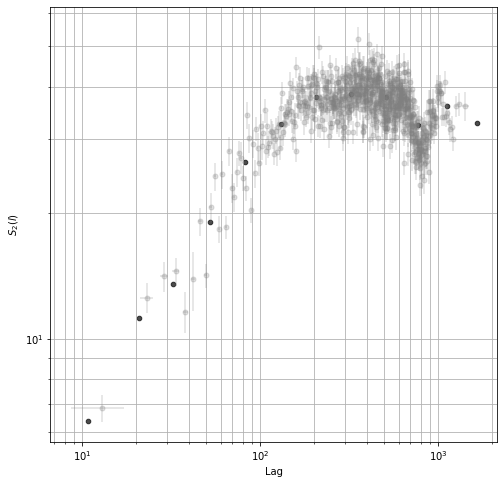

In [37]:
fig, ax=plt.subplots(figsize=(8,8))


ax.errorbar(sfh['Lag'],sfh['Nmqvd'],xerr=sfh.ErrX,yerr=sfh.ErrY, fmt="o", color='gray', alpha=0.25, markersize = 5)
plt.scatter(sfh2.s['mean'],sfh2.dV2['mean'], marker=".", color='black', alpha=0.7,  s = 85)

#plt.scatter(table0['lag']['mean'],table0['qvd']['mean'], marker="+", color='blue', alpha=0.7,  s = 85)

ax.set(xscale='log',yscale='log')
ax.set(xlabel='Lag', ylabel='$S_{2}(l)$')
plt.grid(True, which="both", ls="-")

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

In [38]:
for i in range(len(table2.s['count'])):
    try:
        if table2.s['count'][i] < 10:
            print(table2.s['count'][i])
            #dic[i] = table2.drop(i, axis=0)
    except KeyError:
        continue

9.0


In [39]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 12.669751167297363 seconds ---
